# Detector versátil de patrones pseudoperiódicos (aip_detector)

El presente trabajo es una reinterpretación del algoritmo original creado por Augusto Santini, Mariano LLamedo Soria y E. Diez programado inicialmente en Matlab. El código fuente se encuentra en el siguiente repositorio:

https://github.com/marianux/ecg-kit/blob/be4410b70341c6d3c1439f9101491c5446b74944/common/aip_detector.m

Para más información, leer el paper relacionado:
"Versatile Detector of Pseudo-periodic Patterns"

Jorge López Luna

### Introducción:
A lo largo del presente documento, aplicaremos y trataremos de explicar el algoritmo. Cómo se usa, parámetros a tener en cuenta y los resultados esperados. Para ello se describirá en detalle las operaciones matemáticas realizadas.

### ¿Qué es un ECG?

Un ECG (Electrocardiograma) es una representación gráfica de la actividad eléctrica de los músculos cardíacos en función del tiempo.
A continuación mostraremos las ondas comunmente vistas en un ECG:

<img src="files/ECG_Ondas.svg">

### ¿Por qué es importante un ECG?

Analizando la morfología y frecuencia de ciertos patrones, es posible determinar casos de patologías cardíacas. Hoy en día, el análisis de un ECG representa una forma de detección temprana de isquemia, infarto, etc.
Mediante el aip_detector, nos proponemos a detectar la ubicación de los puntos R únicamente.

### Empezamos con el código:

Por lo tanto, comenzamos con el detector, cargando un ecg de una base de datos de libre acceso proveída por:

https://physionet.org/

In [1]:
# Cargamos las librerías a utilizar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import scipy
from scipy.signal import lfilter
from scipy.signal import find_peaks

# Cargamos el archivo que contiene el ECG
da , info = wfdb.rdsamp( '100', pb_dir='mitdb/', sampfrom=0, sampto = 30000 , channels=[0])

datos = pd.DataFrame({'hart':da[:,0]})

# Mostramos sólo una parte del ECG cargado
plt.figure()
plt.title("ECG")
plt.plot(datos, alpha=1, color='blue')
axes = plt.gca()
axes.set_xlim([0,2000])
axes.set_ylim([-0.75,1.2])
plt.xlabel('Muestras')
plt.ylabel('V')
plt.show()
    


<Figure size 640x480 with 1 Axes>

### Comienzo del algoritmo:

Antes de comenzar con el algoritmo en cuestión, es necesario explicar su funcionamiento matemático.
Para ello, los autores proponen una señal patrón como la siguiente:

$ p(n) = g(n).\frac{dg(n)}{dn} $ 

Siendo g(n) una función gaussiana

$ g(n) = e^{\frac{-[n-(N/2)]²}{2\varsigma²}} $

Siendo:
N: el largo del patrón (también sería el largo de g(n))

$ \varsigma = \frac{N-1}{5}$ 

¿Por qué utilizamos una forma de onda como la propuesta? Porque de ésta forma tendríamos un patrón arbitrario genérico de contenido impulsivo y "suave", si se quiere. En otras palabras, resultaría en una señal pasabanda.

Como muestra el paper, variando el ancho del patrón en el tiempo, lo hacemos más o menos selectivo en el dominio de la frecuencia:

<img src="files/Patron.png">     <img src="files/Patron_2.png">  

Entonces, al multiplicar la señal patrón por la señal de ECG y luego integrar, notaremos que en las partes donde se encuentra el complejo QRS, el resultado será un número alto, mientras que en el resto dará números pequeños. Multiplicar e integrar ambas señales sería el equivalente a convulusionarlas. 

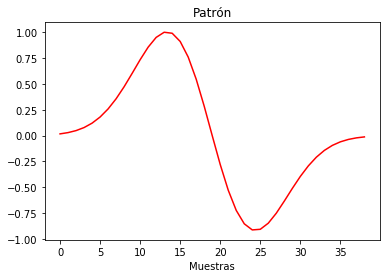

In [2]:

# N: largo del patron (Es seteable por el usuario con el nombre de pattern_width) 
N = 40

# Creamos la gaussiana g(n)
sigma = (N-1)/5
g = scipy.signal.gaussian( N , ((N-1)/5) )

# Creamos el patrón:  p = dg * g

dg = np.diff(g)
g = g[1:]    # Saco el ùltimo elemento para poder multiplicar con misma dimensión
p = dg*g

# Normalizo al patrón      normalize_pattern = true
maxim = np.max(np.abs(p))
p = p/maxim

# Mostramos el patrón
plt.figure()
plt.title("Patrón")
plt.plot(p, alpha=1, color='red')
axes = plt.gca()
plt.xlabel('Muestras')
plt.show()

### Señal de detección:
El algoritmo continúa con el análisis de la señal de detección, basada en la siguiente ecuación:
<img src="files/señal_det.png">  

s(i): La señal bajo análisis

¿Qué significa dicha ecuación?
En procesamiento de señales, sería el equivalente a realizar un "matched filter" el cual se obtiene al correlacionar una señal conocida con cierto retardo, con una señal desconocida para detectar dentro de ella, la presencia de la otra. Ésto sería el equivalente a convolucionar la señal desconocida con la versión invertida en el tiempo de nuestro patrón.


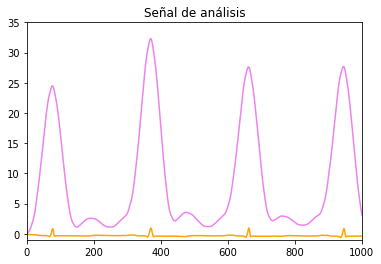

In [3]:
# Filtramos 
s = np.array(datos['hart'])
rise_det = lfilter( p , 1 , np.flip(s))
rise_det = lfilter( p , 1 , np.flip(rise_det))

# Pasabajos
ejemplo = 120e-3
pattern_size = 2*np.round(ejemplo/2*info['fs'])+1
lp_size = np.round(1.2*pattern_size)  #Parametro de entrada
vector = np.ones(int(lp_size))
vector = vector/lp_size
rise_det = lfilter( vector, 1, np.flip(np.abs(rise_det)) )
rise_det = lfilter( vector, 1, np.flip(rise_det) )

# Mostramos el resultado
plt.figure()
plt.title("Señal de análisis")
plt.plot(rise_det, alpha=1, color='violet')
plt.plot(s, alpha=1, color='orange')
axes = plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([-1,35])
plt.show()

### Máximos y threshold
Para obtener la ubicación de los puntos R, utilizamos el percentil. Al seleccionar un threshold de por ejemplo 30, podremos determinar el valor para el cual se encuentran (por encima de él) un 30% de las muestras.
Finalmente, usando la función de librería find_peaks obtenemos los máximos locales.
Notar que para éste momento, tendremos mapeados los puntos R y T del ECG.


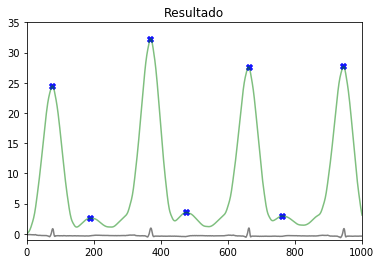

In [4]:
initial_thr = 30
actual_thr = np.percentile(rise_det, initial_thr)  # Valor para el cual se encuentra el 30% de las observaciones
peaks, _ = find_peaks(rise_det, height=actual_thr)
     
plt.figure()
plt.title("Resultado")
plt.plot(rise_det, alpha=0.5, color='green')
plt.plot(s, alpha=0.5, color='black')
axes = plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([-1,35])
plt.scatter(peaks,rise_det[peaks], alpha=0.9, color='blue', marker="X")
plt.show()